# ỨNG DỤNG HỌC MÁY TRONG PHÂN LOẠI HÀM LƯỢNG LYCOPENE TRONG CÀ CHUA DỰA TRÊN DỮ LIỆU QUANG PHỔ

Sinh viên thực hiện: Nguyễn Văn Khải

Khóa: K67 Khoa học dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Xử lí dữ liệu

### Load data

In [ ]:
import os
import re
import numpy as np
import pandas as pd

folder_path = "/content/drive/MyDrive/Tomato/M4,8,9,10_raman/sorted/Ex532"
roi = (500, 3500)

pattern = re.compile(r'\(\s*([\d\.,]+)\s*\)')


def load_spectra_and_labels(folder):
    spectra, names, labels, x_axis = [], [], [], None

    for root, _, files in os.walk(folder):
        for file in files:
            if not file.endswith(".txt"):
                continue

            df = pd.read_csv(os.path.join(root, file), sep=r"\s+", header=None)
            df.columns = ['wn', 'intensity']

            if x_axis is None:
                x_axis = df['wn'].values

            spectra.append(df['intensity'].values)
            names.append(file)

            # extract lycopene label
            match = pattern.search(file)
            if match:
                val_str = match.group(1).replace(',', '.')
                labels.append(float(val_str))
            else:
                labels.append(np.nan)   # nếu không có nhãn

    return np.array(spectra), np.array(names), np.array(labels), x_axis


# Load raw data
spectra_raw, filenames, y, x_axis = load_spectra_and_labels(folder_path)

# Select ROI
roi_mask = (x_axis >= roi[0]) & (x_axis <= roi[1])
X_raw = spectra_raw[:, roi_mask]
x = x_axis[roi_mask]

print("Load data successfully")
print("Shape X:", X_raw.shape)
print("Shape y:", y.shape)

Load data successfully
Shape X: (33, 2061)
Shape y: (33,)


In [ ]:
import numpy as np

# --- 1. Chuẩn bị dữ liệu ---
def get_lycopene_class(val):
    if np.isnan(val): return -1
    if val < 15: return 0       # Low
    elif val <= 40: return 1    # Medium
    else: return 2              # High

# Tạo nhãn lớp dựa trên giá trị y (Lycopene)
y_classes = np.array([get_lycopene_class(val) for val in y])

# Lọc dữ liệu hợp lệ (Loại bỏ các mẫu có y là NaN)
valid_mask = y_classes != -1
X_full_raw = X_raw[valid_mask]
y_full_val = y[valid_mask]
y_full_cls = y_classes[valid_mask]

# --- 2. Thống kê ---
unique_classes = np.unique(y_full_cls)

# Mapping tên lớp để in cho rõ (tùy chọn)
class_names = {0: "0 (Low < 15)", 1: "1 (Med 15-40)", 2: "2 (High > 40)"}

print(f"{'Lycopene Class':<20} | {'Count':<10}")
print("-" * 35)

for c in unique_classes:
    count = np.sum(y_full_cls == c)
    if count > 0:
        name = class_names.get(c, str(c))
        print(f"{name:<20} | {count:<10}")

print("-" * 35)
print(f"Total samples: {len(X_full_raw)}")

Lycopene Class       | Count     
-----------------------------------
0 (Low < 15)         | 20        
1 (Med 15-40)        | 11        
2 (High > 40)        | 2         
-----------------------------------
Total samples: 33


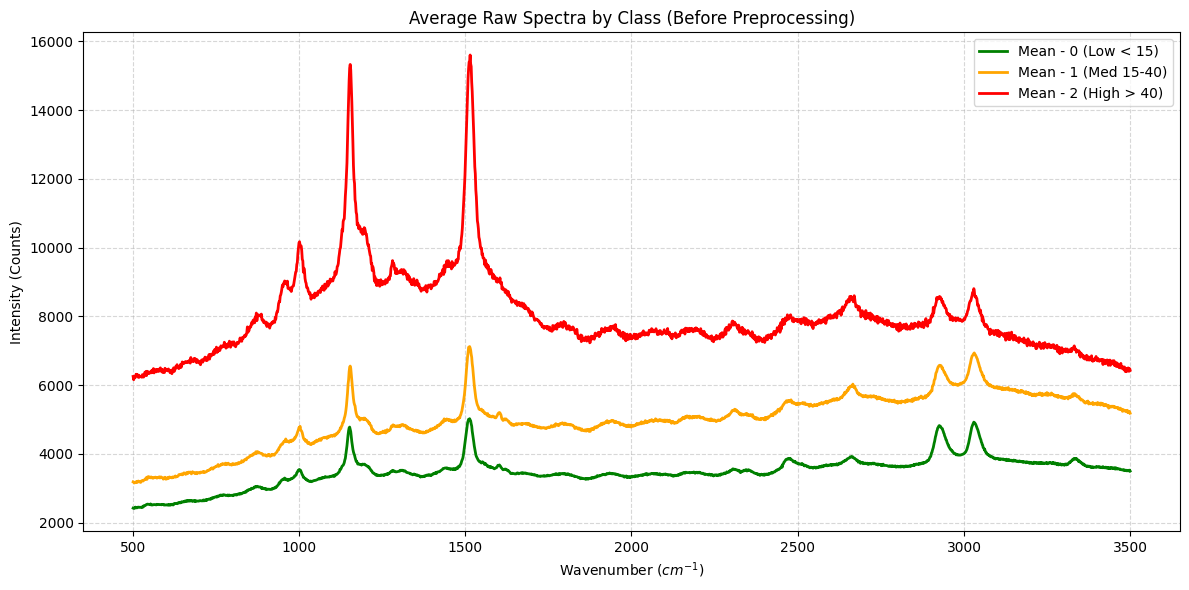

In [ ]:
import matplotlib.pyplot as plt

# Thiết lập màu sắc trực quan: Thấp (Xanh) -> Trung bình (Cam) -> Cao (Đỏ)
colors = {0: 'green', 1: 'orange', 2: 'red'}

plt.figure(figsize=(12, 6))

for c in unique_classes:
    # Lấy các chỉ số (index) thuộc lớp c
    mask = y_full_cls == c
    if np.sum(mask) > 0:
        # Tính trung bình dọc theo trục mẫu (axis 0) của dữ liệu GỐC
        mean_spectrum = np.mean(X_full_raw[mask], axis=0)

        label_name = class_names.get(c, str(c))
        plt.plot(x, mean_spectrum, label=f"Mean - {label_name}",
                 color=colors.get(c, 'blue'), linewidth=2)

plt.title("Average Raw Spectra by Class (Before Preprocessing)")
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (Counts)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Tiền xử lí

In [ ]:
from scipy.ndimage import grey_opening

# --- Định nghĩa hàm Tiền xử lý ---
import numpy as np
from scipy.ndimage import grey_opening

def preprocess_spectra(X_raw, size=100):
    """
    Tiền xử lý phổ Raman/NIR:
    - Khử nền bằng phép biến đổi Top-hat trắng
    Parameters: size : int
    """
    X_processed = []

    for sp in X_raw:
        background = grey_opening(sp, size=size)
        X_processed.append(sp - background)

    return np.asarray(X_processed)

X_proc = preprocess_spectra(X_full_raw, size=100)
print(f"Data shape after preprocessing: {X_proc.shape}")

Data shape after preprocessing: (33, 2061)


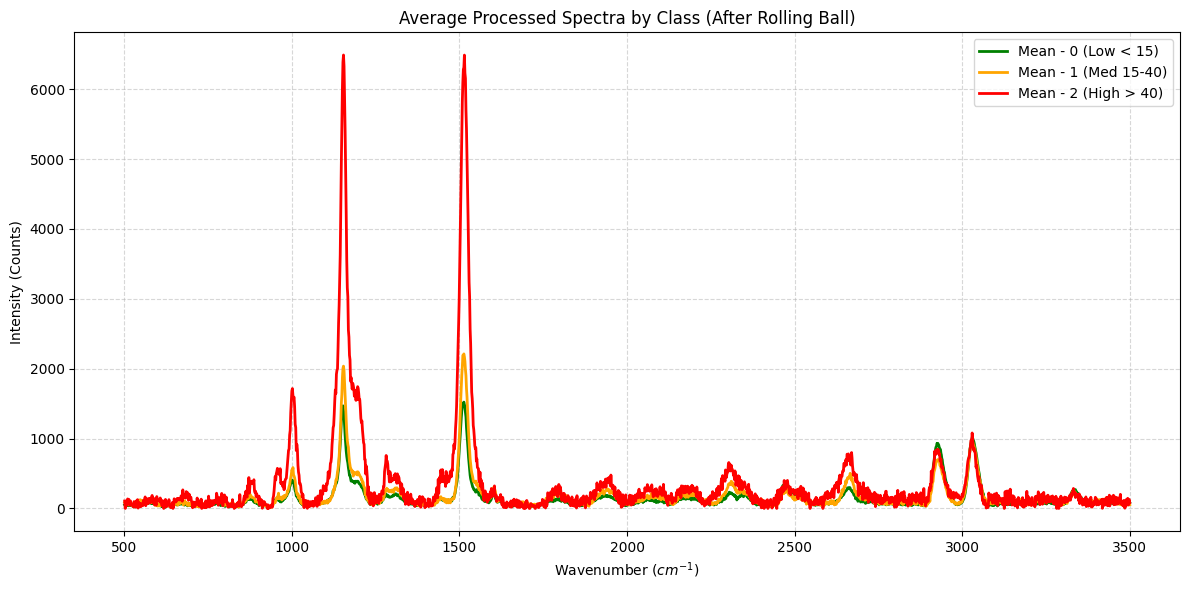

In [ ]:
plt.figure(figsize=(12, 6))

for c in unique_classes:
    # Lấy các chỉ số (index) thuộc lớp c
    mask = y_full_cls == c
    if np.sum(mask) > 0:
        # Tính trung bình dọc theo trục mẫu (axis 0) của dữ liệu ĐÃ XỬ LÝ
        mean_spectrum = np.mean(X_proc[mask], axis=0)

        label_name = class_names.get(c, str(c))
        plt.plot(x, mean_spectrum, label=f"Mean - {label_name}",
                 color=colors.get(c, 'blue'), linewidth=2)

plt.title("Average Processed Spectra by Class (After Rolling Ball)")
plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (Counts)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Chia train test

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# --- Định nghĩa hàm chia dữ liệu  ---
def split(X, y, test_size=0.3, random_state=42):
    """
    Chia dữ liệu gốc thành 2 phần:
    - X_seed: Dùng để làm nguyên liệu sinh dữ liệu tăng cường.
    - X_test: Dùng để test mô hình (Dữ liệu gốc hoàn toàn).
    * Class hiếm (<=2 mẫu hoặc Class 2): Sẽ nằm ở CẢ HAI tập.
    """
    X_seed_list, y_seed_list = [], []
    X_test_list, y_test_list = [], []

    classes = np.unique(y)

    for c in classes:
        mask = (y == c)
        X_sub = X[mask]
        y_sub = y[mask]
        n_samples = len(X_sub)

        # LOGIC CHO CLASS HIẾM (Class 2 hoặc số lượng <= 2)
        if c == 2 or n_samples <= 2:
            # Copy vào Seed (để sinh data giả)
            X_seed_list.append(X_sub)
            y_seed_list.append(y_sub)
            # Copy vào Test (để chấm điểm gốc)
            X_test_list.append(X_sub)
            y_test_list.append(y_sub)

        # LOGIC CHO CLASS THƯỜNG (Chia 70/30)
        else:
            # Lưu ý: train_test_split trả về: X_train, X_test, y_train, y_test
            X_seed_sub, X_test_sub, y_seed_sub, y_test_sub = train_test_split(
                X_sub, y_sub, test_size=test_size, random_state=random_state, stratify=y_sub
            )
            X_seed_list.append(X_seed_sub)
            y_seed_list.append(y_seed_sub)
            X_test_list.append(X_test_sub)
            y_test_list.append(y_test_sub)

    X_seed_final = np.vstack(X_seed_list)
    y_seed_final = np.concatenate(y_seed_list)
    X_test_final = np.vstack(X_test_list)
    y_test_final = np.concatenate(y_test_list)

    return X_seed_final, X_test_final, y_seed_final, y_test_final

X_seed, X_test, y_seed, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

print(f"\nSeed Data Shape (To Augment): {X_seed.shape}")
print(f"Test Data Shape (To Evaluate):  {X_test.shape}")


Seed Data Shape (To Augment): (23, 2061)
Test Data Shape (To Evaluate):  (12, 2061)


SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, classification_report

# --- Hàm hỗ trợ ---
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n Result {model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (Macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("-" * 40)
    print(classification_report(y_true, y_pred))

def process_shap_values(shap_values, n_features):
    if isinstance(shap_values, list):
        shap_sum = np.sum([np.abs(sv) for sv in shap_values], axis=0)
        mean_shap = np.mean(shap_sum, axis=0)
    else:
        shap_abs = np.abs(shap_values)
        if shap_abs.ndim == 3: mean_shap = np.mean(np.sum(shap_abs, axis=2), axis=0)
        elif shap_abs.ndim == 2: mean_shap = np.mean(shap_abs, axis=0)
        else: mean_shap = shap_abs.flatten()

    if mean_shap.size == n_features * 3:
        mean_shap = mean_shap.reshape(3, n_features)
        mean_shap = np.mean(mean_shap, axis=0)
    return mean_shap

def plot_feature_importance(importance_values, x_axis, title, top_n=5):
    importance_values = np.array(importance_values).flatten()
    plt.figure(figsize=(12, 5))
    plt.plot(x_axis, importance_values, color='#d62728', linewidth=1.5, label='SHAP Importance')
    plt.fill_between(x_axis, importance_values, color='#d62728', alpha=0.1)

    top_indices = np.argsort(importance_values)[-top_n:]
    y_max = np.max(importance_values)
    print(f"\nTop {top_n} features for {title}:")
    for idx in top_indices:
        wn = x_axis[idx]
        val = importance_values[idx]
        print(f"  - {wn:.1f} cm-1")
        plt.annotate(f'{wn:.0f}', xy=(wn, val), xytext=(wn, val + y_max*0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                     ha='center', fontsize=9, fontweight='bold')
    plt.title(title, fontsize=14)
    plt.xlabel("Wavenumber ($cm^{-1}$)")
    plt.ylabel("Mean |SHAP| value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def save_and_print_top_features(mean_shap, x_axis, model_name, top_n=20):
    """
    Tạo DataFrame từ kết quả SHAP, sắp xếp giảm dần và lưu file CSV.
    """
    # 1. Tạo DataFrame
    df_shap = pd.DataFrame({
        'Wavenumber (cm-1)': x_axis,
        'Mean |SHAP| Value': mean_shap
    })

    # 2. Sắp xếp giảm dần theo độ quan trọng
    df_sorted = df_shap.sort_values(by='Mean |SHAP| Value', ascending=False).reset_index(drop=True)
    print(f"\nTOP {top_n} QUAN TRỌNG NHẤT ({model_name})")
    print("-" * 50)
    print(df_sorted.head(top_n).to_string(index=False))

    return df_sorted

In [ ]:
shap_results_store = {}

# Mô hình

### XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Result XGBoost
Confusion Matrix:
 [[5 1 0]
 [2 1 1]
 [0 0 2]]
Balanced Accuracy: 0.6944
F1 Score (Macro):  0.6342
----------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.50      0.25      0.33         4
           2       0.67      1.00      0.80         2

    accuracy                           0.67        12
   macro avg       0.63      0.69      0.63        12
weighted avg       0.63      0.67      0.63        12


TOP 20 QUAN TRỌNG NHẤT (XGBoost_Best)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
          3280.500           1.446407
          3284.250           1.203752
           572.954           0.259861
          1699.290           0.204099
          3300.460           0.201006
           787.507           0.167436
          2856.380           0.133799
          1230.160           0.126079
           753.535           0

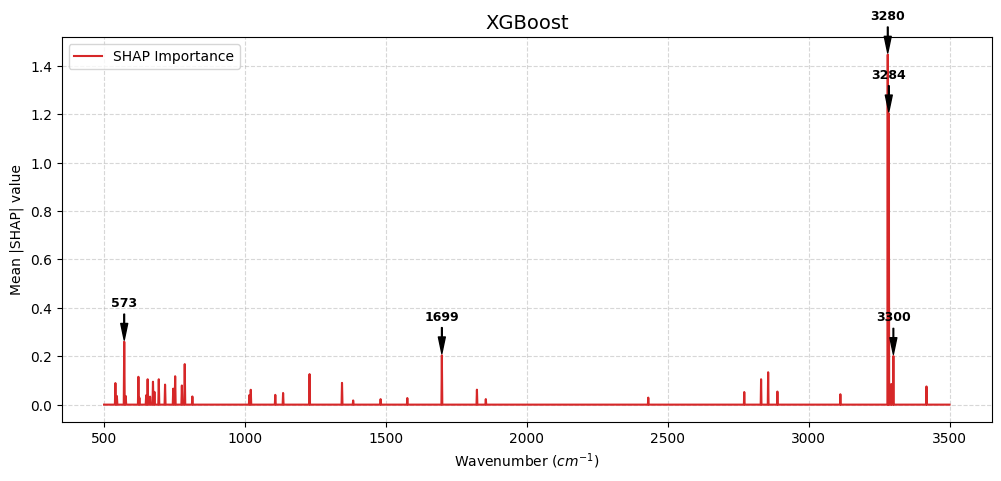

In [ ]:
from xgboost import XGBClassifier
import shap

# Prepare Data
X_train, X_test, y_train, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

# Train Model (Tham số mặc định)
# Loại bỏ GridSearch, khởi tạo trực tiếp mô hình
model_xgb_proc = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss', # Để tránh warning
    n_jobs=-1,              # Sử dụng đa luồng CPU
    random_state=42         # Cố định seed
    # Các tham số khác (n_estimators, max_depth, learning_rate...) sẽ theo mặc định của XGBoost
)

model_xgb_proc.fit(X_train, y_train)

# Evaluate
y_pred = model_xgb_proc.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

# SHAP Calculation
explainer = shap.TreeExplainer(model_xgb_proc)
shap_values = explainer.shap_values(X_test)

# Xử lý SHAP về dạng 1 chiều
mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['XGB_Best'] = mean_shap

# Save & Print
_ = save_and_print_top_features(mean_shap, x, "XGBoost_Best")

# Plot
plot_feature_importance(mean_shap, x, "XGBoost")

### SVM


 Result SVM
Confusion Matrix:
 [[6 0 0]
 [4 0 0]
 [1 0 1]]
Balanced Accuracy: 0.5000
F1 Score (Macro):  0.4575
----------------------------------------
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         4
           2       1.00      0.50      0.67         2

    accuracy                           0.58        12
   macro avg       0.52      0.50      0.46        12
weighted avg       0.44      0.58      0.46        12



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/12 [00:00<?, ?it/s]


TOP 20 QUAN TRỌNG NHẤT (SVM_Best)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
          1510.180           0.016494
          1514.850           0.015298
          1507.070           0.011210
          1513.290           0.010712
          1155.810           0.010433
          1517.950           0.009311
          1152.560           0.008870
          1508.630           0.007878
          1511.740           0.007853
          1516.400           0.006832
          1157.430           0.006350
          1519.510           0.005871
          2032.870           0.005205
          1147.690           0.004863
           873.538           0.004849
          1160.680           0.004807
          2916.700           0.004692
          1159.050           0.004580
          2924.530           0.004474
          1505.510           0.004466

Top 5 features for SVM:
  - 1155.8 cm-1
  - 1513.3 cm-1
  - 1507.1 cm-1
  - 1514.8 cm-1
  - 1510.2 cm-1


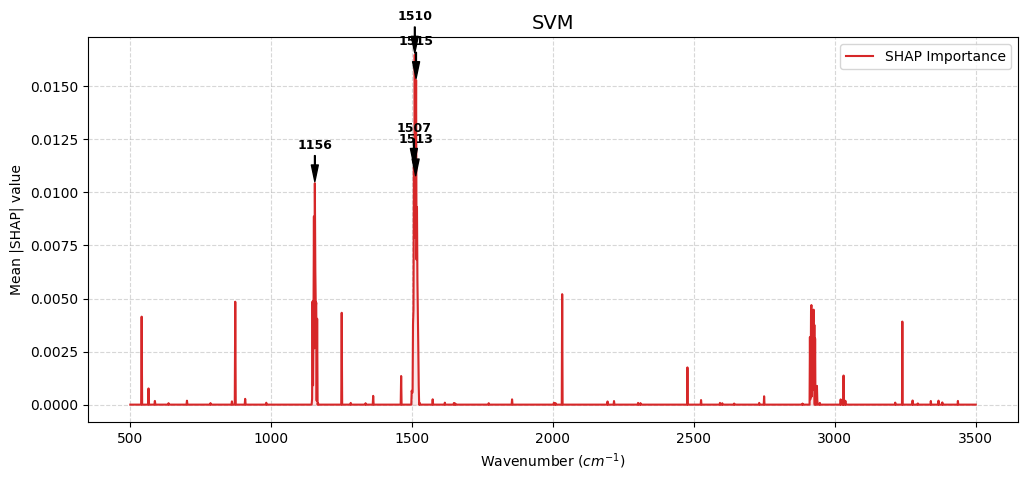

In [ ]:
from sklearn.svm import SVC
import shap

# 1. Train Model
model_svm_proc = SVC(
    probability=True,      # BẮT BUỘC để chạy SHAP KernelExplainer
    random_state=42
)
model_svm_proc.fit(X_train, y_train)

# 2. Evaluate
y_pred = model_svm_proc.predict(X_test)
evaluate_model(y_test, y_pred, "SVM")

# 3. SHAP Calculation (KernelExplainer)
# Tóm tắt dữ liệu nền để chạy nhanh
X_train_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(model_svm_proc.predict_proba, X_train_summary)
shap_values_all = explainer.shap_values(X_test)

# Xử lý output list của KernelExplainer
if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1] if len(shap_values_all) > 1 else shap_values_all[0]
else:
    shap_values = shap_values_all

# Xử lý SHAP
mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['SVM_Best'] = mean_shap

# 4. Save & Print
_ = save_and_print_top_features(mean_shap, x, "SVM_Best")
plot_feature_importance(mean_shap, x, "SVM")

### Decision Tree


 Result Decision Tree
Confusion Matrix:
 [[3 3 0]
 [0 2 2]
 [0 0 2]]
Balanced Accuracy: 0.6667
F1 Score (Macro):  0.5926
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.40      0.50      0.44         4
           2       0.50      1.00      0.67         2

    accuracy                           0.58        12
   macro avg       0.63      0.67      0.59        12
weighted avg       0.72      0.58      0.59        12


TOP 20 QUAN TRỌNG NHẤT (Decision_Tree)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
           3280.50           1.034420
           1787.51           0.463768
           1699.29           0.234601
           2612.87           0.000000
           2614.23           0.000000
           2615.59           0.000000
           2616.95           0.000000
           2618.31           0.000000
           2589.72     

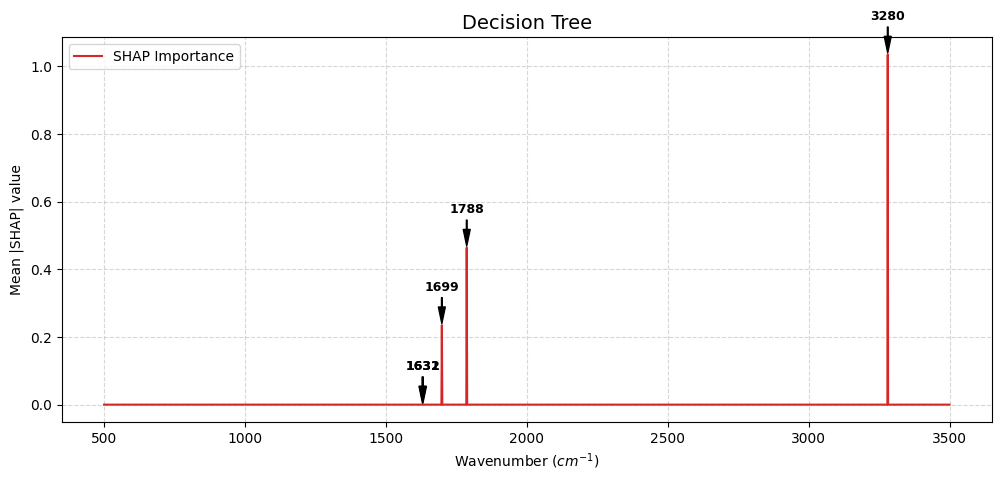

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import shap

# Prepare Data
X_train, X_test, y_train, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

# Train Model (Tham số mặc định)
model_dt = DecisionTreeClassifier(
    random_state=42
)
model_dt.fit(X_train, y_train)

# Evaluate
y_pred = model_dt.predict(X_test)
evaluate_model(y_test, y_pred, "Decision Tree")

# SHAP Calculation
explainer = shap.TreeExplainer(model_dt)
shap_values_all = explainer.shap_values(X_test)

# Xử lý SHAP
if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1] if len(shap_values_all) > 1 else shap_values_all[0]
else:
    shap_values = shap_values_all

mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['Decision_Tree'] = mean_shap

# Save & Plot
_ = save_and_print_top_features(mean_shap, x, "Decision_Tree")
plot_feature_importance(mean_shap, x, "Decision Tree")

### Random Forest


 Result Random Forest
Confusion Matrix:
 [[6 0 0]
 [4 0 0]
 [0 0 2]]
Balanced Accuracy: 0.6667
F1 Score (Macro):  0.5833
----------------------------------------
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         2

    accuracy                           0.67        12
   macro avg       0.53      0.67      0.58        12
weighted avg       0.47      0.67      0.54        12


TOP 20 QUAN TRỌNG NHẤT (Random_Forest)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
          1850.680           0.021446
          2724.890           0.015362
          1652.040           0.013922
          1378.470           0.013279
           536.382           0.012874
           814.589           0.011952
           618.019           0.010630
          3454.540           0.010441
           770.537     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


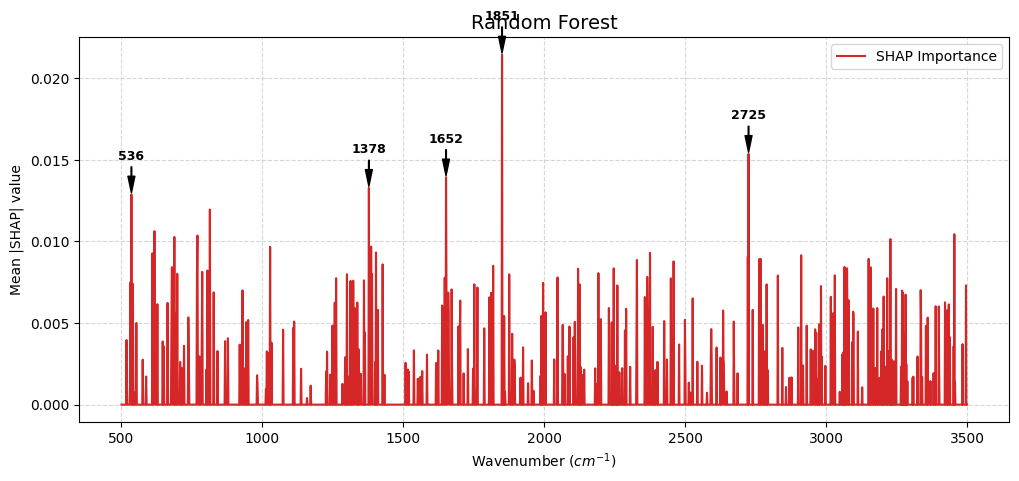

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import shap

# Prepare Data
X_train, X_test, y_train, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

# Train Model (Tham số mặc định: n_estimators=100)
model_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train, y_train)

# Evaluate
y_pred = model_rf.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

# SHAP Calculation
explainer = shap.TreeExplainer(model_rf)
shap_values_all = explainer.shap_values(X_test)

# Xử lý SHAP
if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1] if len(shap_values_all) > 1 else shap_values_all[0]
else:
    shap_values = shap_values_all

mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['Random_Forest'] = mean_shap

# Save & Plot
_ = save_and_print_top_features(mean_shap, x, "Random_Forest")
plot_feature_importance(mean_shap, x, "Random Forest")

### Logistic


 Result Logistic
Confusion Matrix:
 [[6 0 0]
 [3 1 0]
 [0 0 2]]
Balanced Accuracy: 0.7500
F1 Score (Macro):  0.7333
----------------------------------------
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.25      0.40         4
           2       1.00      1.00      1.00         2

    accuracy                           0.75        12
   macro avg       0.89      0.75      0.73        12
weighted avg       0.83      0.75      0.70        12


TOP 20 QUAN TRỌNG NHẤT (Logistic)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
           1510.18           8.687323
           1149.31           6.516114
           1160.68           4.376080
           1511.74           4.093925
           1150.94           3.652832
           1514.85           3.275351
           1141.18           3.235418
           1513.29           2.824219
           1155.81           2.70

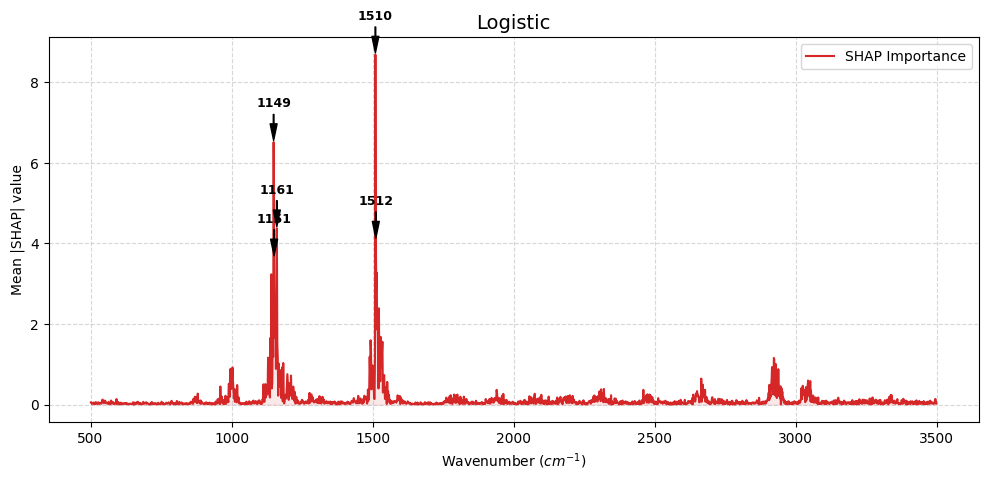

In [ ]:
from sklearn.linear_model import LogisticRegression
import shap

# Prepare Data
X_train, X_test, y_train, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

# Train Model (Tham số mặc định, chỉ tăng max_iter để đảm bảo hội tụ)
model_log = LogisticRegression(
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)
model_log.fit(X_train, y_train)

# Evaluate
y_pred = model_log.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic")

# SHAP Calculation
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(model_log, masker=masker)
shap_values = explainer.shap_values(X_test)

# Xử lý SHAP
mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['Logistic'] = mean_shap

# Save & Plot
_ = save_and_print_top_features(mean_shap, x, "Logistic")
plot_feature_importance(mean_shap, x, "Logistic")

### PLS-DA


 Result PLS-DA
Confusion Matrix:
 [[6 0 0]
 [2 2 0]
 [0 2 0]]
Balanced Accuracy: 0.5000
F1 Score (Macro):  0.4524
----------------------------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.50      0.50      0.50         4
           2       0.00      0.00      0.00         2

    accuracy                           0.67        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.54      0.67      0.60        12


TOP 20 QUAN TRỌNG NHẤT (PLS-DA)
--------------------------------------------------
 Wavenumber (cm-1)  Mean |SHAP| Value
          3382.220           0.005614
           787.507           0.004879
          3292.980           0.004843
           836.532           0.004505
          2601.990           0.004226
          2124.610           0.004181
          2248.140           0.004060
          2431.260           0.004011
          3280.500           0.003966

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


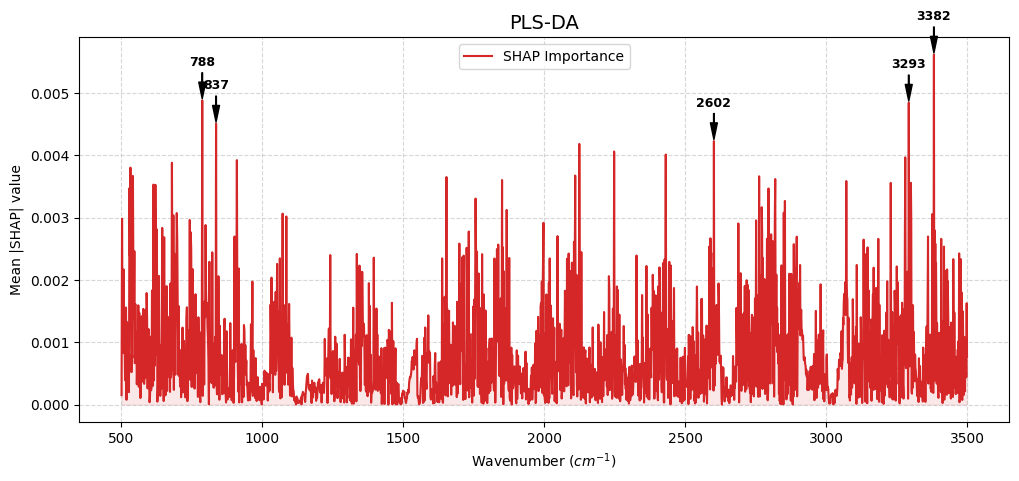

In [ ]:
from sklearn.cross_decomposition import PLSRegression
import shap
import numpy as np

# Prepare Data
X_train, X_test, y_train, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=42)

# Train Model (Mặc định n_components=2 cho PLS)
model_pls = PLSRegression(n_components=2)
model_pls.fit(X_train, y_train)

# Evaluate
y_pred_cont = model_pls.predict(X_test)
y_pred = (y_pred_cont > 0.5).astype(int)
evaluate_model(y_test, y_pred, "PLS-DA")

# SHAP Calculation
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(model_pls, masker=masker)
shap_values = explainer.shap_values(X_test)

# Xử lý SHAP
mean_shap = process_shap_values(shap_values, n_features=len(x))
shap_results_store['PLS_DA'] = mean_shap

# Save & Plot
_ = save_and_print_top_features(mean_shap, x, "PLS-DA")
plot_feature_importance(mean_shap, x, "PLS-DA")

### Tổng hợp kết quả

Đang tổng hợp và so sánh kết quả...


,Model,Balanced Accuracy,F1-Score (Macro),Accuracy (Standard),Top SHAP Feature
0,Logistic Reg,0.750000,0.733300,0.750000,1510.180000
1,XGBoost,0.694400,0.634200,0.666700,3280.500000
2,Decision Tree,0.666700,0.592600,0.583300,3280.500000
3,Random Forest,0.666700,0.583300,0.666700,1850.680000
4,SVM,0.500000,0.457500,0.583300,1516.400000
5,PLS-DA,0.500000,0.452400,0.666700,3382.220000


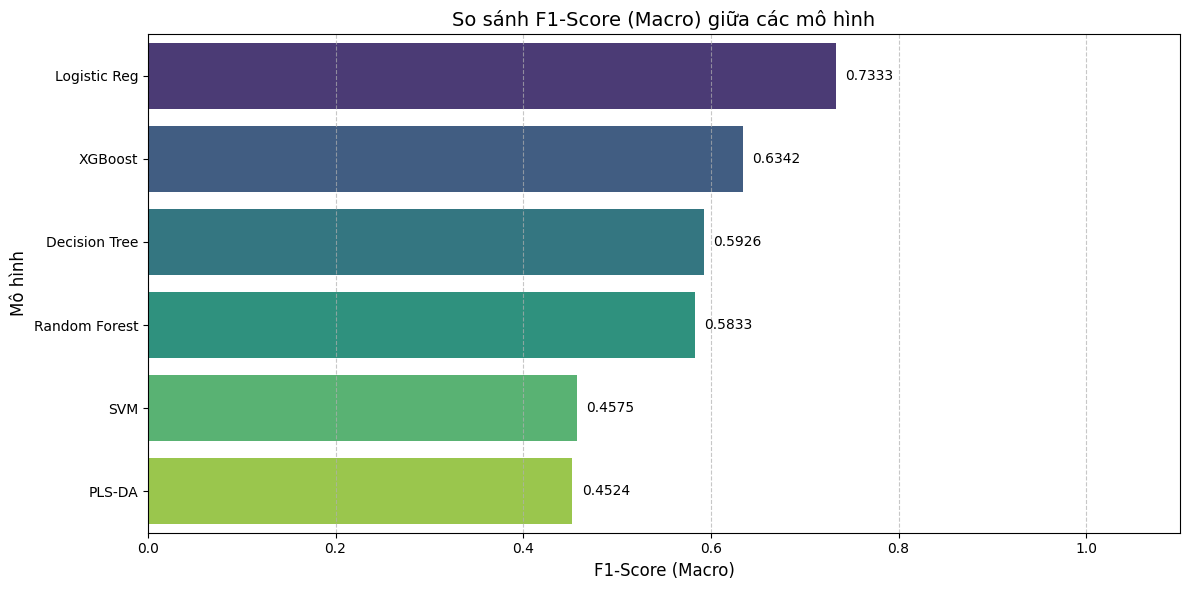

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score

# 1. Tập hợp các mô hình
# (Lưu ý: Các biến này là kết quả từ các cell Grid Search best_estimator_ ở trên)
models_dict = {
    "XGBoost": model_xgb_proc,
    "SVM": model_svm_proc,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    "Logistic Reg": model_log,
    "PLS-DA": model_pls
}

# 2. Mapping key SHAP
# (Phải khớp chính xác với key bạn đã gán vào shap_results_store['KEY_NAME'])
shap_keys_map = {
    "XGBoost": "XGB_Best",
    "SVM": "SVM_Best",            # Đã sửa từ "SVM" thành "SVM_Best"
    "Decision Tree": "Decision_Tree",
    "Random Forest": "Random_Forest",
    "Logistic Reg": "Logistic",
    "KNN": "KNN",
    "PLS-DA": "PLS_DA"
}

results_list = []

print("Đang tổng hợp và so sánh kết quả...")

for name, model in models_dict.items():
    # 3. Dự đoán
    # PLS-DA là hồi quy nên cần threshold, các model khác là classifier
    if name == "PLS-DA":
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)

    # 4. Tính toán Metrics
    b_acc = balanced_accuracy_score(y_test, y_pred)
    f1_mac = f1_score(y_test, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # 5. Lấy Top 1 Feature SHAP (Wavenumber quan trọng nhất)
    top_feature = "N/A"
    store_key = shap_keys_map.get(name)

    if store_key in shap_results_store:
        shap_vals = shap_results_store[store_key]
        # Kiểm tra dimension của shap_vals để lấy argmax đúng
        if isinstance(shap_vals, list):
            # Trường hợp shap trả về list các class (như KNN KernelExplainer)
            shap_vals = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]

        top_idx = np.argmax(np.abs(shap_vals)) # Lấy trị tuyệt đối vì SHAP có thể âm
        top_feature = round(x[top_idx], 2) # Làm tròn số sóng

    results_list.append({
        "Model": name,
        "Balanced Accuracy": round(b_acc, 4),
        "F1-Score (Macro)": round(f1_mac, 4),
        "Accuracy (Standard)": round(acc, 4),
        "Top SHAP Feature": top_feature
    })

# 6. Tạo DataFrame
df_results = pd.DataFrame(results_list)

# Sắp xếp ưu tiên theo F1-Macro (chỉ số quan trọng nhất cho lớp không cân bằng)
df_results = df_results.sort_values(by="F1-Score (Macro)", ascending=False).reset_index(drop=True)

# 7. Hiển thị bảng màu
display(df_results.style.background_gradient(cmap='Greens', subset=['Balanced Accuracy', 'F1-Score (Macro)']))

# 8. Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df_results, x='F1-Score (Macro)', y='Model', palette='viridis', hue='Model', legend=False)

plt.title('So sánh F1-Score (Macro) giữa các mô hình', fontsize=14)
plt.xlabel('F1-Score (Macro)', fontsize=12)
plt.ylabel('Mô hình', fontsize=12)
plt.xlim(0, 1.1) # Để chừa chỗ cho text

# Thêm nhãn giá trị lên cột
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tăng cường dữ liệu ở vùng quan tâm

### Lấy kết quả SHAP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_top_shap_indices(shap_store, model_key, top_n=5):
    """
    Lấy ra danh sách các chỉ số (index) có giá trị SHAP trung bình cao nhất
    của một mô hình cụ thể.
    """
    if model_key not in shap_store:
        print(f"Lỗi: Không tìm thấy key '{model_key}' trong shap_store.")
        return np.array([])

    # Lấy giá trị SHAP raw
    shap_values = shap_store[model_key]
    importance = np.abs(shap_values)

    # Lấy Top N chỉ số cao nhất
    top_indices = np.argsort(importance)[-top_n:]

    return np.sort(top_indices)

## Grid param augmentation + model

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight


# --- 1. Smart Noise ---
def apply_smart_noise(spec, target_indices, window=15, bg_noise_level=0.05, roi_ratio=0.2):
    new_spec = spec.copy()
    n_points = len(spec)
    max_val = np.max(spec)

    mask = np.zeros(n_points, dtype=bool)
    for idx in target_indices:
        start = max(0, idx - window)
        end = min(n_points, idx + window)
        mask[start:end] = True

    noise = np.random.normal(0, max_val * bg_noise_level, size=n_points)
    noise[mask] *= roi_ratio

    new_spec += noise

    if np.random.rand() > 0.5:
        scale_factor = np.random.uniform(0.95, 1.05)
        new_spec *= scale_factor

    return np.maximum(new_spec, 0)

# --- 2. Local Shift ---
def apply_local_shift(spec, target_indices, shift_range=(-5, 6), window=15):
    new_spec = spec.copy()
    n_points = len(spec)
    x = np.arange(n_points)
    f = interp1d(x, spec, kind='linear', fill_value="extrapolate")

    shift_val = np.random.randint(shift_range[0], shift_range[1])
    if shift_val == 0: return new_spec

    mask = np.zeros(n_points, dtype=bool)
    for idx in target_indices:
        start = max(0, idx - window)
        end = min(n_points, idx + window)
        mask[start:end] = True

    new_spec[mask] = f(x[mask] - shift_val)
    return new_spec

# --- HÀM GENERATE ---
def generate_roi_augment(X_seed, y_seed, target_indices, aug_config, num_per_class=100, seed=42):
    rng = np.random.RandomState(seed)
    X_aug, y_aug = [], []
    classes = np.unique(y_seed)

    # Unpack config
    window = aug_config.get('window', 10)
    bg_noise = aug_config.get('bg_noise', 0.005)
    roi_ratio = aug_config.get('roi_ratio', 0.1)
    shift_r = aug_config.get('shift', (-5, 6))

    print(f"   Generating {num_per_class} samples/class...")

    for cls in classes:
        idxs_cls = np.where(y_seed == cls)[0]
        X_cls = X_seed[idxs_cls]
        n_seeds = len(X_cls)

        # FIX: Cho phép sinh dữ liệu dù chỉ có 1 mẫu
        if n_seeds == 0: continue

        # --- LOGIC MỚI: DUYỆT TUẦN TỰ XOAY VÒNG (ROUND-ROBIN) ---
        # Đảm bảo các mẫu gốc được dùng với tần suất bằng nhau tuyệt đối
        for i in range(num_per_class):
            # i chạy từ 0 đến num_per_class-1
            # idx_base sẽ xoay vòng: 0, 1, 0, 1... (nếu n_seeds=2)
            idx_base = i % n_seeds

            spec_base = X_cls[idx_base]

            # 50% Noise, 50% Shift
            choice = rng.randint(0, 2)
            if choice == 0:
                spec_new = apply_smart_noise(spec_base, target_indices, window=window, bg_noise_level=bg_noise, roi_ratio=roi_ratio)
            else:
                spec_new = apply_local_shift(spec_base, target_indices, shift_range=shift_r, window=window)

            X_aug.append(spec_new)
            y_aug.append(cls)

    return np.array(X_aug), np.array(y_aug)

### XGB

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

# --- CONFIGURATION ---
MODEL_KEY = 'XGB_Best'
TOP_N_PEAKS = 5
RANDOM_STATE = 42

# --- 1. DATA PREPARATION (Fixed Real Splits) ---
# Lấy ROI indices
roi_indices = get_top_shap_indices(shap_results_store, MODEL_KEY, top_n=TOP_N_PEAKS)

# Split Test (Real) riêng biệt
# (Giả sử hàm split của bạn là custom_split_overlap_rare như các bước trước)
X_train_all, X_test, y_train_all, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=RANDOM_STATE)

# Split Train thành Real Train và Real Valid
# Lưu ý: X_valid_real được giữ cố định để so sánh công bằng giữa các lần Augment
X_train_real, X_valid_real, y_train_real, y_valid_real = train_test_split(
    X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=RANDOM_STATE
)

print(f"Original Train: {X_train_real.shape} | Fixed Valid: {X_valid_real.shape} | Test: {X_test.shape}")

# --- 2. DEFINE GRIDS ---
# A. Lưới tham số Augmentation (Bao gồm cả số lượng mẫu sinh thêm)
AUG_PARAM_GRID = {
    'num_per_class': [20, 50, 100, 150],     # <--- THAM SỐ MỚI: Số lượng mẫu sinh thêm
    'bg_noise': [0.005, 0.01, 0.02],            # Noise nền
    'roi_ratio': [0.2],                  # Tỷ lệ noise tại ROI (cố định 0.2 cho gọn nếu muốn)
    'window': [10, 15],                      # Window (có thể cố định hoặc grid)
    'shift': [(-4, 5), (-7, 8)]          # Shift range
}

# B. Lưới tham số XGBoost (Inner Loop)
XGB_PARAM_GRID = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'learning_rate': [0.005, 0.01, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# --- 3. EXECUTE GRID SEARCH ---
best_global_score = -1
best_global_params = {}
results_history = []

# Tạo danh sách các tổ hợp tham số Augment
aug_combinations = list(ParameterGrid(AUG_PARAM_GRID))
total_iter = len(aug_combinations)

for i, aug_config in enumerate(aug_combinations):
    # Lấy số lượng mẫu cần sinh từ config hiện tại
    n_samples = aug_config['num_per_class']

    print(f"\n[Iter {i+1}/{total_iter}] Aug Config: Samples={n_samples} | Noise={aug_config['bg_noise']} | Shift={aug_config['shift']}")

    # Bước 3.1: Sinh dữ liệu Augment mới
    X_aug, y_aug = generate_roi_augment(
        X_train_real, y_train_real, roi_indices,
        aug_config=aug_config,
        num_per_class=n_samples,
        seed=42
    )

    # Bước 3.2: Gộp dữ liệu (Real Train + Aug Train)
    X_train_final = np.vstack([X_train_real, X_aug])
    y_train_final = np.hstack([y_train_real, y_aug])

    # Bước 3.3: Tạo Weights & PredefinedSplit
    w_train = compute_sample_weight(class_weight='balanced', y=y_train_final)
    w_valid = np.ones(len(y_valid_real))
    w_combined = np.hstack([w_train, w_valid])

    # Gộp Train Final + Fixed Valid cho GridSearch
    X_combined = np.vstack([X_train_final, X_valid_real])
    y_combined = np.hstack([y_train_final, y_valid_real])

    # Tạo chỉ dẫn fold: -1 là train, 0 là valid
    test_fold = [-1] * len(X_train_final) + [0] * len(X_valid_real)
    ps = PredefinedSplit(test_fold)

    # Bước 3.4: Chạy GridSearch cho XGBoost (Inner Loop)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)

    # Inner GridSearch verbose=0 để gọn gàng
    inner_grid = GridSearchCV(xgb, XGB_PARAM_GRID, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=0)
    inner_grid.fit(X_combined, y_combined, sample_weight=w_combined)

    # Bước 3.5: Lưu kết quả
    current_best_score = inner_grid.best_score_
    current_best_model_params = inner_grid.best_params_

    print(f"   -> Best Inner Val F1: {current_best_score:.4f} | XGB Params: {current_best_model_params}")

    results_history.append({
        'aug_config': aug_config,
        'model_params': current_best_model_params,
        'val_score': current_best_score,
        'best_estimator': inner_grid.best_estimator_
    })

    # Cập nhật Global Best
    if current_best_score > best_global_score:
        best_global_score = current_best_score
        best_global_params = {
            'aug': aug_config,
            'model': current_best_model_params,
            'estimator': inner_grid.best_estimator_
        }

# --- 4. FINAL EVALUATION ---
print(f"Best Validation F1: {best_global_score:.4f}")
print(f"Best Aug Params:   {best_global_params['aug']}")
print(f"Best XGB Params:   {best_global_params['model']}")

# Test trên tập Test độc lập
final_model = best_global_params['estimator']
y_test_pred = final_model.predict(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

###SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

# --- CONFIGURATION ---
MODEL_KEY = 'SVM_Best'
TOP_N_PEAKS = 5
RANDOM_STATE = 42

# --- 1. DATA PREPARATION (Fixed Real Splits) ---
# Lấy ROI indices
roi_indices = get_top_shap_indices(shap_results_store, MODEL_KEY, top_n=TOP_N_PEAKS)

# Split Test (Real) riêng biệt
X_train_all, X_test, y_train_all, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=RANDOM_STATE)

# Split Train thành Real Train và Real Valid (Cố định Valid)
# Lưu ý: X_valid_real được giữ cố định để so sánh công bằng giữa các lần Augment
X_train_real, X_valid_real, y_train_real, y_valid_real = train_test_split(
    X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=RANDOM_STATE
)

print(f"Original Train: {X_train_real.shape} | Fixed Valid: {X_valid_real.shape} | Test: {X_test.shape}")

# --- 2. DEFINE GRIDS ---
# A. Lưới tham số Augmentation (Bao gồm cả số lượng mẫu sinh thêm)
AUG_PARAM_GRID = {
    'num_per_class': [10, 20, 50, 100, ],
    'bg_noise': [0.0001,0.001, 0.005, 0.01, 0.05, 0.1],
    'roi_ratio': [0.05, 0.1, 0.3, 0.5],
    'window': [7, 10, 15],
    'shift': [(-3,4),(-4, 5), (-7, 8)]
}

# B. Lưới tham số SVM (Inner Loop)
SVM_PARAM_GRID = {
    'C': [1, 10, 50, 100],            # Regularization parameter
    'gamma': ['scale', 0.1, 0.01],    # Kernel coefficient
    'kernel': ['rbf']                 # RBF thường tốt nhất cho phổ
}
# --- 3. EXECUTE TRIPLE GRID SEARCH ---
best_global_score = -1
best_global_params = {}
results_history = []

# Tạo danh sách các tổ hợp tham số Augment
aug_combinations = list(ParameterGrid(AUG_PARAM_GRID))
total_iter = len(aug_combinations)

for i, aug_config in enumerate(aug_combinations):
    # Lấy số lượng mẫu cần sinh từ config hiện tại
    n_samples = aug_config['num_per_class']

    print(f"\n[Iter {i+1}/{total_iter}] Aug Config: Samples={n_samples} | Noise={aug_config['bg_noise']} | Shift={aug_config['shift']}")

    # Bước 3.1: Sinh dữ liệu Augment mới
    X_aug, y_aug = generate_roi_augment(
        X_train_real, y_train_real, roi_indices,
        aug_config=aug_config,
        num_per_class=n_samples,  # <--- Truyền tham số số lượng mẫu
        seed=42
    )

    # Bước 3.2: Gộp dữ liệu (Real Train + Aug Train)
    X_train_final = np.vstack([X_train_real, X_aug])
    y_train_final = np.hstack([y_train_real, y_aug])

    # Bước 3.3: Tạo PredefinedSplit (Train Final + Fixed Valid)
    X_combined = np.vstack([X_train_final, X_valid_real])
    y_combined = np.hstack([y_train_final, y_valid_real])

    # -1: Train set, 0: Validation set
    test_fold = [-1] * len(X_train_final) + [0] * len(X_valid_real)
    ps = PredefinedSplit(test_fold)

    # Bước 3.4: Chạy GridSearch cho SVM (Inner Loop)
    # class_weight='balanced' là chìa khóa để SVM học tốt trên data lai
    svm = SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE)

    inner_grid = GridSearchCV(svm, SVM_PARAM_GRID, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=0)
    inner_grid.fit(X_combined, y_combined)

    # Bước 3.5: Lưu kết quả
    current_best_score = inner_grid.best_score_
    current_best_model_params = inner_grid.best_params_

    results_history.append({
        'aug_config': aug_config,
        'model_params': current_best_model_params,
        'val_score': current_best_score,
        'best_estimator': inner_grid.best_estimator_
    })

    # Cập nhật Global Best
    if current_best_score > best_global_score:
        best_global_score = current_best_score
        best_global_params = {
            'aug': aug_config,
            'model': current_best_model_params,
            'estimator': inner_grid.best_estimator_
        }

# --- 4. FINAL EVALUATION ---
print(f"Best Validation F1: {best_global_score:.4f}")
print(f"Best Aug Params:   {best_global_params['aug']}")
print(f"Best SVM Params:   {best_global_params['model']}")

# Test trên tập Test độc lập
final_model = best_global_params['estimator']
y_test_pred = final_model.predict(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Lỗi: Không tìm thấy key 'SVM_Best' trong shap_store.
Original Train: (16, 2061) | Fixed Valid: (7, 2061) | Test: (12, 2061)

[Iter 1/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-3, 4)
   Generating 10 samples/class...

[Iter 2/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-3, 4)
   Generating 10 samples/class...

[Iter 3/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-3, 4)
   Generating 10 samples/class...

[Iter 4/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-4, 5)
   Generating 10 samples/class...

[Iter 5/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-4, 5)
   Generating 10 samples/class...

[Iter 6/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-4, 5)
   Generating 10 samples/class...

[Iter 7/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-7, 8)
   Generating 10 samples/class...

[Iter 8/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=(-7, 8)
   Generating 10 samples/class...

[Iter 9/864] Aug Config: Samples=10 | Noise=0.0001 | Shift=

###Logistic

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

# --- CONFIGURATION ---
MODEL_KEY = 'Logistic'
TOP_N_PEAKS = 5
RANDOM_STATE = 42

# --- 1. DATA PREPARATION ---
roi_indices = get_top_shap_indices(shap_results_store, MODEL_KEY, top_n=TOP_N_PEAKS)

# Split Test (Real)
X_train_all, X_test, y_train_all, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=RANDOM_STATE)

# Split Train (Real) & Valid (Real)
X_train_real, X_valid_real, y_train_real, y_valid_real = train_test_split(
    X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=RANDOM_STATE
)

print(f"Original Train: {X_train_real.shape} | Fixed Valid: {X_valid_real.shape} | Test: {X_test.shape}")

# --- 2. DEFINE GRIDS ---
# A. Augmentation Grid
AUG_PARAM_GRID = {
    'num_per_class': [20, 50, 100, 150],
    'bg_noise': [0.005, 0.01, 0.015, 0.03],
    'roi_ratio': [0.1, 0.3],
    'window': [7, 10, 15],
    'shift': [(-4, 5), (-7, 8), (-10, 11)]
}

# B. Logistic Regression Grid
LOGREG_PARAM_GRID = {
    'C': [0.1, 1, 10, 50, 100],        # Inverse regularization strength
    'penalty': ['l2'],                 # L2 Ridge regression (tốt cho dữ liệu cộng tuyến như phổ)
    'solver': ['lbfgs', 'liblinear']   # Các bộ giải tối ưu
}

# --- 3. EXECUTE TRIPLE GRID SEARCH ---
best_global_score = -1
best_global_params = {}

aug_combinations = list(ParameterGrid(AUG_PARAM_GRID))
total_iter = len(aug_combinations)

for i, aug_config in enumerate(aug_combinations):
    n_samples = aug_config['num_per_class']
    print(f"\n[Iter {i+1}/{total_iter}] Aug Config: Samples={n_samples} | Noise={aug_config['bg_noise']}")

    # 3.1 Generate Data
    X_aug, y_aug = generate_roi_augment(
        X_train_real, y_train_real, roi_indices,
        aug_config=aug_config, num_per_class=n_samples, seed=42
    )

    # 3.2 Combine Data
    X_train_final = np.vstack([X_train_real, X_aug])
    y_train_final = np.hstack([y_train_real, y_aug])

    # 3.3 Predefined Split
    X_combined = np.vstack([X_train_final, X_valid_real])
    y_combined = np.hstack([y_train_final, y_valid_real])

    test_fold = [-1] * len(X_train_final) + [0] * len(X_valid_real)
    ps = PredefinedSplit(test_fold)

    # 3.4 Grid Search Logistic Regression
    # max_iter tăng lên để đảm bảo hội tụ trên dữ liệu nhiều chiều
    logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE)

    inner_grid = GridSearchCV(logreg, LOGREG_PARAM_GRID, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=0)
    inner_grid.fit(X_combined, y_combined)

    # 3.5 Store Results
    current_best_score = inner_grid.best_score_
    print(f"   -> Best Inner Val F1: {current_best_score:.4f} | Params: {inner_grid.best_params_}")

    if current_best_score > best_global_score:
        best_global_score = current_best_score
        best_global_params = {
            'aug': aug_config,
            'model': inner_grid.best_params_,
            'estimator': inner_grid.best_estimator_
        }

# --- 4. FINAL EVALUATION ---
print(f"Best Validation F1: {best_global_score:.4f}")
print(f"Best Aug Params:   {best_global_params['aug']}")
print(f"Best LogReg Params:{best_global_params['model']}")

final_model = best_global_params['estimator']
y_test_pred = final_model.predict(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Lỗi: Không tìm thấy key 'Logistic' trong shap_store.
Original Train: (16, 2061) | Fixed Valid: (7, 2061) | Test: (12, 2061)

[Iter 1/288] Aug Config: Samples=20 | Noise=0.005
   Generating 20 samples/class...
   -> Best Inner Val F1: 0.1667 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

[Iter 2/288] Aug Config: Samples=20 | Noise=0.005
   Generating 20 samples/class...
   -> Best Inner Val F1: 0.1667 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

[Iter 3/288] Aug Config: Samples=20 | Noise=0.005
   Generating 20 samples/class...
   -> Best Inner Val F1: 0.1667 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

[Iter 4/288] Aug Config: Samples=20 | Noise=0.005
   Generating 20 samples/class...
   -> Best Inner Val F1: 0.1667 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

[Iter 5/288] Aug Config: Samples=20 | Noise=0.005
   Generating 20 samples/class...
   -> Best Inner Val F1: 0.1667 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

[Iter

###DT

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# --- CONFIGURATION ---
MODEL_KEY = 'Decision_Tree'
TOP_N_PEAKS = 5
RANDOM_STATE = 42

# --- 1. DATA PREPARATION (Fixed Real Splits) ---
# Lấy ROI indices (Indices quan trọng nhất đối với DT để Augment đúng chỗ)
roi_indices = get_top_shap_indices(shap_results_store, MODEL_KEY, top_n=TOP_N_PEAKS)

# Split Test (Real) riêng biệt
X_train_all, X_test, y_train_all, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=RANDOM_STATE)

# Split Train thành Real Train và Real Valid (Cố định Valid)
X_train_real, X_valid_real, y_train_real, y_valid_real = train_test_split(
    X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=RANDOM_STATE
)

print(f"Original Train: {X_train_real.shape} | Fixed Valid: {X_valid_real.shape} | Test: {X_test.shape}")

# --- 2. DEFINE GRIDS ---
# A. Lưới tham số Augmentation
AUG_PARAM_GRID = {
    # Thêm 0 để cho phép model chọn phương án "Không Augment" nếu dữ liệu gốc đã tốt
    'num_per_class': [0, 20, 50, 100],
    'bg_noise': [0.0001, 0.001, 0.005, 0.01, 0.05], # Noise nền
    'roi_ratio': [0.1, 0.3],                        # Noise tại ROI thấp hơn
    'window': [7, 10, 15],
    'shift': [(-3, 4), (-5, 6)]
}

# B. Lưới tham số Decision Tree (Inner Loop)
DT_PARAM_GRID = {
    'criterion': ['gini', 'entropy'],           # Tiêu chí phân chia
    'max_depth': [None, 5, 10, 15, 20],         # Kiểm soát độ sâu để tránh overfit với data nhiễu
    'min_samples_leaf': [1, 2, 4],              # Số mẫu tối thiểu tại lá (Smoothing)
    'class_weight': ['balanced', None]          # Cân bằng lớp
}

# --- 3. EXECUTE TRIPLE GRID SEARCH ---
best_global_score = -1
best_global_params = {}
results_history = []

aug_combinations = list(ParameterGrid(AUG_PARAM_GRID))
total_iter = len(aug_combinations)

print(f"\nStarting Optimized Search for Decision Tree...")

for i, aug_config in enumerate(aug_combinations):
    n_samples = aug_config['num_per_class']

    # --- LOGIC XỬ LÝ: CLEAN vs AUGMENTED ---
    if n_samples == 0:
        # Trường hợp Baseline: Chỉ dùng dữ liệu thật
        X_train_final = X_train_real
        y_train_final = y_train_real

        # Trọng số chuẩn
        w_train = compute_sample_weight(class_weight='balanced', y=y_train_final)
        print(f"\n[Iter {i+1}/{total_iter}] Config: NO AUGMENTATION (Clean Baseline)")

    else:
        # Trường hợp Augmentation
        X_aug, y_aug = generate_roi_augment(
            X_train_real, y_train_real, roi_indices,
            aug_config=aug_config, num_per_class=n_samples, seed=42
        )

        # Gộp dữ liệu
        X_train_final = np.vstack([X_train_real, X_aug])
        y_train_final = np.hstack([y_train_real, y_aug])

        # --- KỸ THUẬT TRUST BOOSTING (Quan trọng cho DT) ---
        # Decision Tree rất dễ bị nhiễu làm thay đổi cấu trúc cây.
        # Ta ép trọng số mẫu thật cao gấp đôi mẫu giả.
        w_real = compute_sample_weight(class_weight='balanced', y=y_train_real)
        w_aug = compute_sample_weight(class_weight='balanced', y=y_aug)

        w_train = np.hstack([w_real * 2.0, w_aug * 1.0])

        print(f"\n[Iter {i+1}/{total_iter}] Config: Samples={n_samples} | Noise={aug_config['bg_noise']} | Shift={aug_config['shift']}")

    # --- CHUẨN BỊ VALIDATION ---
    # Valid set luôn có weight = 1 (đánh giá công bằng)
    w_valid = np.ones(len(y_valid_real))
    w_combined = np.hstack([w_train, w_valid])

    # Combine Train Final + Fixed Valid
    X_combined = np.vstack([X_train_final, X_valid_real])
    y_combined = np.hstack([y_train_final, y_valid_real])

    # Predefined Split (-1: Train, 0: Valid)
    test_fold = [-1] * len(X_train_final) + [0] * len(X_valid_real)
    ps = PredefinedSplit(test_fold)

    # --- GRID SEARCH DECISION TREE ---
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

    inner_grid = GridSearchCV(dt, DT_PARAM_GRID, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=0)

    # Truyền sample_weight vào fit
    inner_grid.fit(X_combined, y_combined, sample_weight=w_combined)

    # --- STORE RESULTS ---
    current_best_score = inner_grid.best_score_
    current_best_model_params = inner_grid.best_params_

    print(f"   -> Best Inner Val F1: {current_best_score:.4f} | DT Params: {current_best_model_params}")

    results_history.append({
        'aug_config': aug_config,
        'model_params': current_best_model_params,
        'val_score': current_best_score,
        'best_estimator': inner_grid.best_estimator_
    })

    # Cập nhật Global Best
    if current_best_score > best_global_score:
        best_global_score = current_best_score
        best_global_params = {
            'aug': aug_config,
            'model': current_best_model_params,
            'estimator': inner_grid.best_estimator_
        }

# --- 4. FINAL EVALUATION ---
print(f"Best Aug Params: {best_global_params['aug']}")
print(f"Best DT Params:  {best_global_params['model']}")

final_model = best_global_params['estimator']
y_test_pred = final_model.predict(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Lỗi: Không tìm thấy key 'Decision_Tree' trong shap_store.
Original Train: (16, 2061) | Fixed Valid: (7, 2061) | Test: (12, 2061)

Starting Optimized Search for Decision Tree...

[Iter 1/240] Config: NO AUGMENTATION (Clean Baseline)
   -> Best Inner Val F1: 0.3833 | DT Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

[Iter 2/240] Config: NO AUGMENTATION (Clean Baseline)
   -> Best Inner Val F1: 0.3833 | DT Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

[Iter 3/240] Config: NO AUGMENTATION (Clean Baseline)
   -> Best Inner Val F1: 0.3833 | DT Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

[Iter 4/240] Config: NO AUGMENTATION (Clean Baseline)
   -> Best Inner Val F1: 0.3833 | DT Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

[Iter 5/240] Config: NO AUGMENTATION (Clean Baseline)


## Chạy 1 lần

### Tăng cường DL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.utils.class_weight import compute_sample_weight

# --- 1. CẤU HÌNH TỐI ƯU ---
# Tham số tốt nhất bạn tìm được từ Grid Search
BEST_AUG_PARAMS = {
    'bg_noise': 0.005,
    'num_per_class': 20,
    'roi_ratio': 0.1,
    'shift': (-4, 5),
    'window': 7
}
RANDOM_STATE = 42
TOP_N_PEAKS = 5
MODEL_KEY = 'Logistic'

# --- 2. DATA PREPARATION ---

# 2.1 Lấy ROI indices
roi_indices = get_top_shap_indices(shap_results_store, MODEL_KEY, top_n=TOP_N_PEAKS)

# 2.2 Split Test (Real) riêng biệt
X_train_all, X_test, y_train_all, y_test = split(X_proc, y_full_cls, test_size=0.3, random_state=RANDOM_STATE)

# 2.3 Split Train thành Real Train và Real Valid (Cố định Valid để so sánh)
X_train_real, X_valid_real, y_train_real, y_valid_real = train_test_split(
    X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=RANDOM_STATE
)

print(f"   - Original Train: {X_train_real.shape}")
print(f"   - Fixed Valid:    {X_valid_real.shape} (Dữ liệu thật dùng để Valid)")
print(f"   - Test Data:      {X_test.shape}")

# --- 3. TĂNG CƯỜNG DỮ LIỆU (CHỈ TRÊN REAL TRAIN) ---
X_aug, y_aug = generate_roi_augment(
    X_train_real, y_train_real, roi_indices,
    aug_config=BEST_AUG_PARAMS,
    num_per_class=BEST_AUG_PARAMS['num_per_class'],
    seed=RANDOM_STATE
)

# 3.1 Gộp dữ liệu (Real Train + Aug Train) -> Tạo thành tập Train hỗn hợp
X_train_final = np.vstack([X_train_real, X_aug])
y_train_final = np.hstack([y_train_real, y_aug])

# --- 4. CHUẨN BỊ CHO GRID SEARCH MODEL ---
# Gộp Train Final + Fixed Valid (Dữ liệu thật)
X_combined = np.vstack([X_train_final, X_valid_real])
y_combined = np.hstack([y_train_final, y_valid_real])

# 4.1 Tạo chỉ dẫn fold: -1 là train, 0 là valid
# Điều này ép GridSearch phải train trên tập hỗn hợp và test trên tập thật
test_fold = [-1] * len(X_train_final) + [0] * len(X_valid_real)
ps = PredefinedSplit(test_fold)

# 4.2 Tạo sample_weight (Tùy chọn: Có thể dùng hoặc không, ở đây dùng để giống cell grid)
# Train samples: weight balanced, Valid samples: weight 1
w_train = compute_sample_weight(class_weight='balanced', y=y_train_final)
w_valid = np.ones(len(y_valid_real))
w_combined = np.hstack([w_train, w_valid])
print(f"   - Final Train Size: {X_train_final.shape} (Gồm {len(X_train_real)} thật + {len(X_aug)} giả)")
print(f"   - Validation Size:  {X_valid_real.shape} (Hoàn toàn là thật)")

Lỗi: Không tìm thấy key 'Logistic' trong shap_store.
   - Original Train: (16, 2061)
   - Fixed Valid:    (7, 2061) (Dữ liệu thật dùng để Valid)
   - Test Data:      (12, 2061)
   Generating 20 samples/class...
   - Final Train Size: (76, 2061) (Gồm 16 thật + 60 giả)
   - Validation Size:  (7, 2061) (Hoàn toàn là thật)


### SVM

Fitting 1 folds for each of 30 candidates, totalling 30 fits
   - Best Params: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
   - Best Valid F1: 0.3016
Balanced Accuracy: 0.6667
F1 Macro:          0.7111


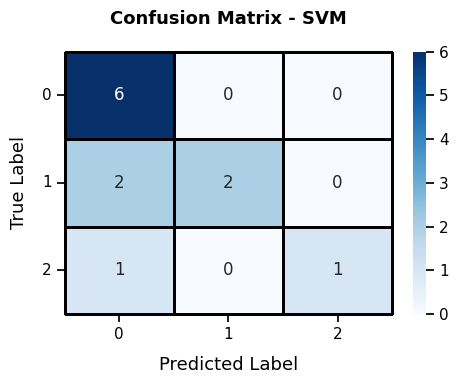

Model saved to 'model_svm_best.pkl'


In [ ]:
from sklearn.svm import SVC
import joblib

# 1. Cấu hình Lưới tham số
svm_params = {
    'C': [1, 10, 50, 100, 200],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

# 2. Grid Search
svm = SVC(probability=True, random_state=RANDOM_STATE)

grid_svm = GridSearchCV(svm, svm_params, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_svm.fit(X_combined, y_combined, sample_weight=w_combined)

# 3. Kết quả & Đánh giá
best_svm = grid_svm.best_estimator_
print(f"   - Best Params: {grid_svm.best_params_}")
print(f"   - Best Valid F1: {grid_svm.best_score_:.4f}")

# Test độc lập
y_pred = best_svm.predict(X_test)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")

# --- 4. Vẽ Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred)
classes = grid_svm.classes_ # Lấy tên các lớp tự động (0, 1, 2)

plt.figure(figsize=(5, 4))
sns.set_context("notebook", font_scale=1) # Tăng kích thước chữ
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            linewidths=1, linecolor='black', clip_on=False)

plt.title(f'Confusion Matrix - SVM',
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, labelpad=10)
plt.ylabel('True Label', fontsize=13, labelpad=10)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Lưu mô hình
joblib.dump(best_svm, 'model_svm_best.pkl')
print("Model saved to 'model_svm_best.pkl'")

### Logistic

Fitting 1 folds for each of 20 candidates, totalling 20 fits
   - Best Params: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
   - Best Valid F1: 0.1667
Balanced Accuracy: 0.8333
F1 Macro:          0.8413


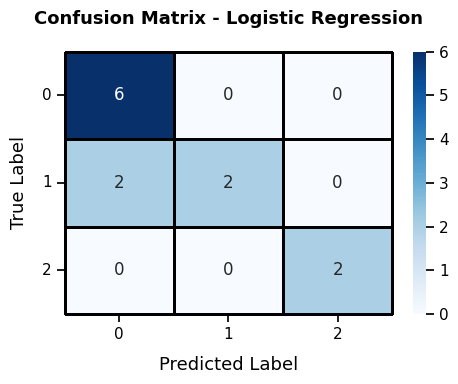

Model saved to 'model_logistic_best.pkl'


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
import joblib

# 1. Cấu hình Lưới tham số
log_params = {
    'C': [0.1, 1, 10, 50, 100],         # Độ mạnh điều chuẩn
    'solver': ['lbfgs', 'liblinear'],   # Thuật toán tối ưu
    'class_weight': ['balanced', None]  # Cân bằng lớp
}

# 2. Grid Search (Chỉ train model)
log = LogisticRegression(max_iter=3000, random_state=RANDOM_STATE, n_jobs=-1)

grid_log = GridSearchCV(log, log_params, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_log.fit(X_combined, y_combined, sample_weight=w_combined)

# 3. Kết quả & Đánh giá
best_log = grid_log.best_estimator_
print(f"   - Best Params: {grid_log.best_params_}")
print(f"   - Best Valid F1: {grid_log.best_score_:.4f}")

# Test độc lập
y_pred = best_log.predict(X_test)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")

# --- 4. Vẽ Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred)
classes = grid_svm.classes_ # Lấy tên các lớp tự động (0, 1, 2)

plt.figure(figsize=(5, 4))
sns.set_context("notebook", font_scale=1) # Tăng kích thước chữ
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            linewidths=1, linecolor='black', clip_on=False)

plt.title(f'Confusion Matrix - Logistic Regression',
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, labelpad=10)
plt.ylabel('True Label', fontsize=13, labelpad=10)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Lưu mô hình
joblib.dump(best_log, 'model_logistic_best.pkl')
print("Model saved to 'model_logistic_best.pkl'")

###DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import joblib

# 1. Cấu hình Lưới tham số
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# 2. Grid Search
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid_dt = GridSearchCV(dt, dt_params, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_dt.fit(X_combined, y_combined, sample_weight=w_combined)

# 3. Kết quả & Đánh giá
best_dt = grid_dt.best_estimator_
print(f"   - Best Params: {grid_dt.best_params_}")
print(f"   - Best Valid F1: {grid_dt.best_score_:.4f}")

# Test độc lập
y_pred = best_dt.predict(X_test)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")
print(confusion_matrix(y_test, y_pred))

# 4. Lưu mô hình
joblib.dump(best_dt, 'model_dt_best.pkl')
print("Model saved to 'model_dt_best.pkl'")

Fitting 1 folds for each of 180 candidates, totalling 180 fits
   - Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
   - Best Valid F1: 0.4630
Balanced Accuracy: 0.6667
F1 Macro:          0.5833
[[6 0 0]
 [4 0 0]
 [0 0 2]]
Model saved to 'model_dt_best.pkl'


### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# 1. Cấu hình Lưới tham số
rf_params = {
    'n_estimators': [100, 200, 300],      # Số lượng cây
    'max_depth': [10, 20, None],          # Độ sâu tối đa
    'min_samples_split': [2, 5],          # Số mẫu tối thiểu để chia nút
    'class_weight': ['balanced', None]    # Cân bằng trọng số
}

# 2. Grid Search
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

grid_rf = GridSearchCV(rf, rf_params, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_rf.fit(X_combined, y_combined, sample_weight=w_combined)

# 3. Kết quả & Đánh giá
best_rf = grid_rf.best_estimator_
print(f"   - Best Params: {grid_rf.best_params_}")
print(f"   - Best Valid F1: {grid_rf.best_score_:.4f}")

# Test độc lập
y_pred = best_rf.predict(X_test)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")
print(confusion_matrix(y_test, y_pred))

# 4. Lưu mô hình
joblib.dump(best_rf, 'model_rf_best.pkl')
print("Model saved to 'model_rf_best.pkl'")

Fitting 1 folds for each of 36 candidates, totalling 36 fits
   - Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
   - Best Valid F1: 0.2000
Balanced Accuracy: 0.6667
F1 Macro:          0.5833
[[6 0 0]
 [4 0 0]
 [0 0 2]]
Model saved to 'model_rf_best.pkl'


### XGB

Fitting 1 folds for each of 108 candidates, totalling 108 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:27:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   - Best Params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
   - Best Valid F1: 0.3016
Balanced Accuracy: 0.6944
F1 Macro:          0.6342


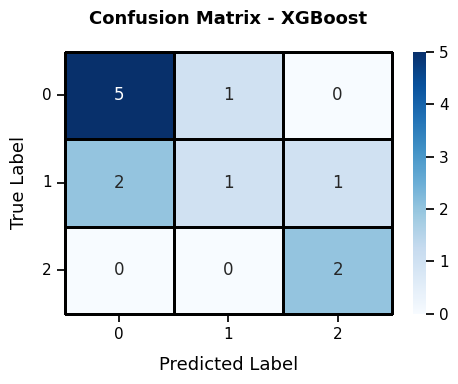

Model saved to 'model_xgb_best.pkl'


In [ ]:
from xgboost import XGBClassifier
import joblib

# 1. Cấu hình Lưới tham số
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8]
}

# 2. Grid Search
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

grid_xgb = GridSearchCV(xgb, xgb_params, cv=ps, scoring='f1_macro', n_jobs=-1, verbose=1)
# XGBoost hỗ trợ sample_weight rất tốt
grid_xgb.fit(X_combined, y_combined, sample_weight=w_combined)

# 3. Kết quả & Đánh giá
best_xgb = grid_xgb.best_estimator_
print(f"   - Best Params: {grid_xgb.best_params_}")
print(f"   - Best Valid F1: {grid_xgb.best_score_:.4f}")

# Test độc lập
y_pred = best_xgb.predict(X_test)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")

# --- 4. Vẽ Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred)
classes = grid_svm.classes_ # Lấy tên các lớp tự động (0, 1, 2)

plt.figure(figsize=(5, 4))
sns.set_context("notebook", font_scale=1) # Tăng kích thước chữ
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            linewidths=1, linecolor='black', clip_on=False)

plt.title(f'Confusion Matrix - XGBoost',
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, labelpad=10)
plt.ylabel('True Label', fontsize=13, labelpad=10)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Lưu mô hình
joblib.dump(best_xgb, 'model_xgb_best.pkl')
print("Model saved to 'model_xgb_best.pkl'")

### PLS-DA

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer
import joblib

# 1. Custom Scorer (Vì PLS trả về giá trị thực, cần ngưỡng 0.5 để ra class)
def pls_f1_scorer(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(int)
    return f1_score(y_true, y_pred_bin, average='macro')

custom_scorer = make_scorer(pls_f1_scorer)

# 2. Cấu hình Lưới tham số
# Tính max components an toàn dựa trên số features và số mẫu
max_comp = min(X_combined.shape[1], X_combined.shape[0])
limit_comp = min(max_comp, 20) # Giới hạn 20 để không chạy quá lâu
n_comp_range = list(range(1, limit_comp + 1))

pls_params = {
    'n_components': n_comp_range,
    'scale': [True, False]
}

# 3. Grid Search
pls = PLSRegression()

# Lưu ý: PLS KHÔNG hỗ trợ sample_weight trong hàm fit, nên ta bỏ qua w_combined ở đây
grid_pls = GridSearchCV(pls, pls_params, cv=ps, scoring=custom_scorer, n_jobs=-1, verbose=1)
grid_pls.fit(X_combined, y_combined)

# 4. Kết quả & Đánh giá
best_pls = grid_pls.best_estimator_
print(f"   - Best Params: {grid_pls.best_params_}")
print(f"   - Best Valid F1: {grid_pls.best_score_:.4f}")

# Test độc lập
y_pred_cont = best_pls.predict(X_test)
y_pred = (y_pred_cont > 0.5).astype(int)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Macro:          {f1_score(y_test, y_pred, average='macro'):.4f}")
print(confusion_matrix(y_test, y_pred))

# 5. Lưu mô hình
joblib.dump(best_pls, 'model_pls_best.pkl')
print("Model saved to 'model_pls_best.pkl'")

Fitting 1 folds for each of 40 candidates, totalling 40 fits
   - Best Params: {'n_components': 1, 'scale': False}
   - Best Valid F1: 0.3889
Balanced Accuracy: 0.6667
F1 Macro:          0.6040
[[6 0 0]
 [0 4 0]
 [1 1 0]]
Model saved to 'model_pls_best.pkl'


### Results

>>> ĐANG TỔNG HỢP KẾT QUẢ TRÊN TẬP TEST ĐỘC LẬP...

=== BẢNG XẾP HẠNG HIỆU NĂNG (FINAL TEST SET) ===


,Model,F1-Macro,Balanced Accuracy,Accuracy
0,Logistic Regression,0.841270,0.833333,0.833333
1,SVM,0.711111,0.666667,0.750000
2,XGBoost,0.634188,0.694444,0.666667
3,PLS-DA,0.603989,0.666667,0.833333
4,Random Forest,0.583333,0.666667,0.666667
5,Decision Tree,0.583333,0.666667,0.666667


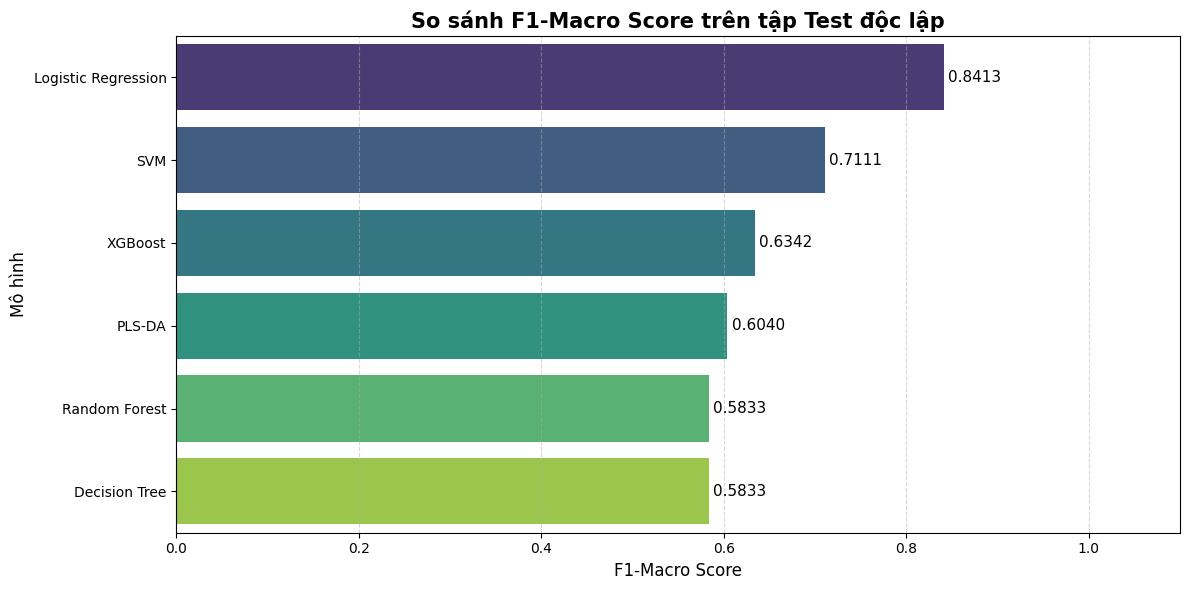

MÔ HÌNH TỐT NHẤT: Logistic Regression
Tham số chi tiết:
{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 3000, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

# 1. Tập hợp các model đã tối ưu (Best Estimators từ các bước trên)
trained_models = {
    "Logistic Regression": best_log,
    "SVM": best_svm,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "PLS-DA": best_pls,
    "XGBoost": best_xgb
}

results_data = []

print(">>> ĐANG TỔNG HỢP KẾT QUẢ TRÊN TẬP TEST ĐỘC LẬP...")

for name, model in trained_models.items():
    # 2. Dự đoán
    # Xử lý riêng cho PLS-DA (vì output là regression continuous)
    if name == "PLS-DA":
        y_pred_cont = model.predict(X_test)
        y_pred = (y_pred_cont > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)

    # 3. Tính toán các chỉ số
    f1 = f1_score(y_test, y_pred, average='macro')
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results_data.append({
        "Model": name,
        "F1-Macro": f1,
        "Balanced Accuracy": bal_acc,
        "Accuracy": acc
    })

# 4. Tạo DataFrame và Sắp xếp
df_results = pd.DataFrame(results_data)
# Sắp xếp theo F1-Macro giảm dần (Ưu tiên mô hình cân bằng tốt nhất)
df_results = df_results.sort_values(by="F1-Macro", ascending=False).reset_index(drop=True)

# 5. Hiển thị bảng màu (Highlight model tốt nhất)
print("\n=== BẢNG XẾP HẠNG HIỆU NĂNG (FINAL TEST SET) ===")
# Tô màu xanh lá đậm cho giá trị cao, nhạt cho giá trị thấp
display(df_results.style.background_gradient(cmap='Greens', subset=['F1-Macro', 'Balanced Accuracy', 'Accuracy']))

# 6. Vẽ biểu đồ so sánh trực quan
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_results, x='F1-Macro', y='Model', palette='viridis', hue='Model', legend=False)

plt.title('So sánh F1-Macro Score trên tập Test độc lập', fontsize=15, fontweight='bold')
plt.xlabel('F1-Macro Score', fontsize=12)
plt.ylabel('Mô hình', fontsize=12)
plt.xlim(0, 1.1)  # Để dư chỗ cho text

# Thêm nhãn giá trị lên từng cột
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3, fontsize=11)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. In ra tham số của Model vô địch
best_model_name = df_results.iloc[0]['Model']
print(f"MÔ HÌNH TỐT NHẤT: {best_model_name}")
print("Tham số chi tiết:")
# Lấy object model từ dictionary
winner_model = trained_models[best_model_name]
print(winner_model.get_params())